Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    correct_count = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    return correct_count / predictions.shape[0] * 100

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
class Bunch(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

def make_dense(x, size, activation=None, weights_regularizer=None):
    # Note: this is similar to `tf.layers.dense`.
    w = tf.get_variable('weights', [x.shape[1], size],
                        initializer=tf.truncated_normal_initializer(),
                        regularizer=weights_regularizer)
    b = tf.get_variable('biases', [size], initializer=tf.zeros_initializer())
    outputs = tf.nn.xw_plus_b(x, w, b)
    if activation is not None:
        outputs = activation(outputs)
    return outputs

def make_logistic_regression():
    def model_fn(inputs):
        with tf.variable_scope('logits'):
            logits = make_dense(inputs.data, inputs.labels.shape[1],
                                weights_regularizer=tf.nn.l2_loss)
        outputs = tf.nn.softmax(logits)
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=inputs.labels, logits=logits))
        return outputs, loss
    return model_fn

def make_nn(hidden_sizes=(1024,)):
    def model_fn(inputs):
        last_output = inputs.data
        for i, hidden_size in enumerate(hidden_sizes):
            with tf.variable_scope('fc{}'.format(i)):
                layer = make_dense(last_output, hidden_size, activation=tf.nn.relu,
                                   weights_regularizer=tf.nn.l2_loss)
                layer = tf.nn.dropout(layer, inputs.keep_prob)
            last_output = layer
        with tf.variable_scope('logits'):
            logits = make_dense(last_output, inputs.labels.shape[1],
                                weights_regularizer=tf.nn.l2_loss)
        outputs = tf.nn.softmax(logits)
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=inputs.labels, logits=logits))
        return outputs, loss
    return model_fn

def make_gradient_descent(learning_rate=0.5):
    def train_fn(loss):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train_op = optimizer.minimize(loss)
        return train_op
    return train_fn

running logistic regression without regularization
loss at step 0: 20.4
batch accuracy: 7.0%
validation accuracy: 8.3%
loss at step 500: 1.5
batch accuracy: 76.6%
validation accuracy: 75.3%
loss at step 1000: 1.5
batch accuracy: 78.9%
validation accuracy: 77.0%
loss at step 1500: 1.1
batch accuracy: 77.3%
validation accuracy: 77.8%
loss at step 2000: 1.0
batch accuracy: 76.6%
validation accuracy: 78.0%
loss at step 2500: 1.0
batch accuracy: 78.1%
validation accuracy: 77.9%
loss at step 3000: 0.5
batch accuracy: 83.6%
validation accuracy: 79.3%
test accuracy: 86.5%


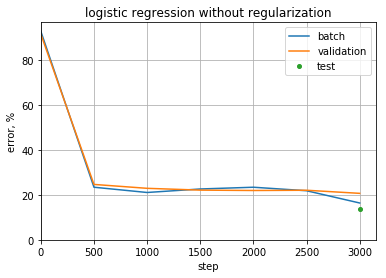

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def run(title, model_fn, train_fn=None, num_steps=3001, batch_size=128,
        regularization_strength=0.0, dropout_keep_prob=1.0,
        train_data=train_dataset, train_labels=train_labels,
        valid_data=valid_dataset, valid_labels=valid_labels,
        test_data=test_dataset, test_labels=test_labels):
    print('running', title)

    graph = tf.Graph()
    with graph.as_default():
        data = tf.placeholder(tf.float32, [None, train_data.shape[1]])
        labels = tf.placeholder(tf.float32, [None, train_labels.shape[1]])
        keep_prob = tf.placeholder(tf.float32)
        predictions, loss = model_fn(Bunch(data=data,
                                           labels=labels,
                                           keep_prob=keep_prob))
        if regularization_strength is not None:
            loss += regularization_strength * tf.reduce_sum(
                tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        if train_fn is None:
            train_fn = make_gradient_descent()
        train_op = train_fn(loss)
    
    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()
        batch_accuracies = []
        valid_accuracies = []
        steps = []
        for step in range(num_steps):
            offset = step * batch_size % (train_data.shape[0] - batch_size)
            batch_data = train_data[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            _, batch_loss, batch_predictions = sess.run(
                [train_op, loss, predictions],
                feed_dict={
                    data: batch_data,
                    labels: batch_labels,
                    keep_prob: dropout_keep_prob,
                })
            if step % 500 == 0:
                batch_accuracy = accuracy(batch_predictions, batch_labels)
                valid_predicitons = predictions.eval({data: valid_dataset, keep_prob: 1.0})
                valid_accuracy = accuracy(valid_predicitons, valid_labels)
                print('loss at step {}: {:.1f}'.format(step, batch_loss))
                print('batch accuracy: {:.1f}%'.format(batch_accuracy))
                print('validation accuracy: {:.1f}%'.format(valid_accuracy))
                batch_accuracies.append(batch_accuracy)
                valid_accuracies.append(valid_accuracy)
                steps.append(step)
        test_predicitons = predictions.eval({data: test_dataset, keep_prob: 1.0})
        test_accuracy = accuracy(test_predicitons, test_labels)
        print('test accuracy: {:.1f}%'.format(test_accuracy))

        def to_errors(accuracies):
            return [100 - x for x in accuracies]
        plt.plot(steps, to_errors(batch_accuracies), label='batch')
        plt.plot(steps, to_errors(valid_accuracies), label='validation')
        plt.plot(steps[-1:], to_errors([test_accuracy]), '.', markersize=8, label='test')
        plt.gca().set_xticks(steps)
        plt.gca().set_xlim(xmin=0)
        plt.gca().set_ylim(ymin=0)
        plt.title(title)
        plt.xlabel('step')
        plt.ylabel('error, %')
        plt.legend()
        plt.grid()
        plt.show()

run('logistic regression without regularization', make_logistic_regression())

running logistic regression with regularization
loss at step 0: 49.0
batch accuracy: 12.5%
validation accuracy: 12.3%
loss at step 500: 0.9
batch accuracy: 80.5%
validation accuracy: 79.2%
loss at step 1000: 0.8
batch accuracy: 82.8%
validation accuracy: 81.4%
loss at step 1500: 0.8
batch accuracy: 78.9%
validation accuracy: 81.1%
loss at step 2000: 0.7
batch accuracy: 83.6%
validation accuracy: 81.7%
loss at step 2500: 0.8
batch accuracy: 83.6%
validation accuracy: 81.7%
loss at step 3000: 0.5
batch accuracy: 89.8%
validation accuracy: 81.5%
test accuracy: 87.8%


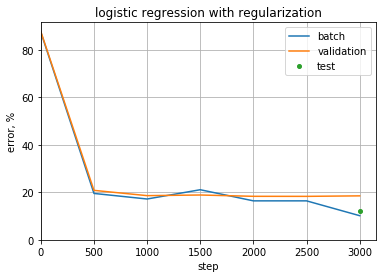

In [7]:
run('logistic regression with regularization',
    make_logistic_regression(), regularization_strength=0.01)

running neural network without regularization
loss at step 0: 320.1
batch accuracy: 14.1%
validation accuracy: 32.0%
loss at step 500: 10.6
batch accuracy: 82.0%
validation accuracy: 81.5%
loss at step 1000: 20.3
batch accuracy: 74.2%
validation accuracy: 80.7%
loss at step 1500: 10.0
batch accuracy: 79.7%
validation accuracy: 79.8%
loss at step 2000: 2.2
batch accuracy: 83.6%
validation accuracy: 81.1%
loss at step 2500: 11.1
batch accuracy: 82.8%
validation accuracy: 80.9%
loss at step 3000: 2.2
batch accuracy: 86.7%
validation accuracy: 81.3%
test accuracy: 88.4%


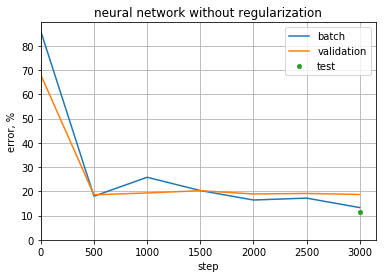

In [8]:
run('neural network without regularization', make_nn())

running neural network with regularization
loss at step 0: 3500.1
batch accuracy: 7.8%
validation accuracy: 28.8%
loss at step 500: 21.3
batch accuracy: 84.4%
validation accuracy: 83.6%
loss at step 1000: 0.9
batch accuracy: 82.0%
validation accuracy: 83.7%
loss at step 1500: 0.7
batch accuracy: 83.6%
validation accuracy: 83.6%
loss at step 2000: 0.7
batch accuracy: 84.4%
validation accuracy: 84.0%
loss at step 2500: 0.7
batch accuracy: 86.7%
validation accuracy: 84.0%
loss at step 3000: 0.5
batch accuracy: 89.8%
validation accuracy: 83.6%
test accuracy: 89.6%


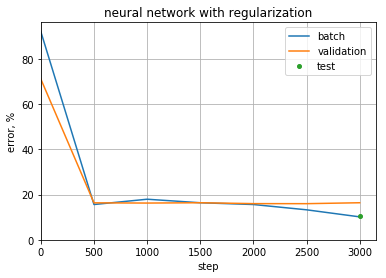

In [9]:
run('neural network with regularization',
    make_nn(), regularization_strength=0.01)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

running neural network with a small dataset and no regularization
loss at step 0: 349.9
batch accuracy: 8.6%
validation accuracy: 24.2%
loss at step 500: 0.0
batch accuracy: 100.0%
validation accuracy: 77.4%
loss at step 1000: 0.0
batch accuracy: 100.0%
validation accuracy: 77.4%
loss at step 1500: 0.0
batch accuracy: 100.0%
validation accuracy: 77.4%
loss at step 2000: 0.0
batch accuracy: 100.0%
validation accuracy: 77.4%
loss at step 2500: 0.0
batch accuracy: 100.0%
validation accuracy: 77.4%
loss at step 3000: 0.0
batch accuracy: 100.0%
validation accuracy: 77.4%
test accuracy: 84.7%


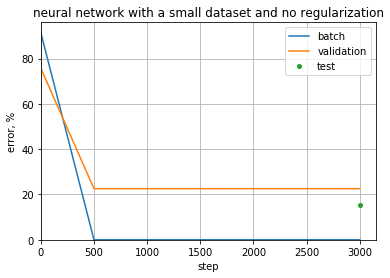

In [10]:
run('neural network with a small dataset and no regularization',
    make_nn(),
    train_data=train_dataset[:1000, :], train_labels=train_labels[:1000, :])

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

running neural network with a small dataset, no regularization, and dropout
loss at step 0: 504.0
batch accuracy: 8.6%
validation accuracy: 33.6%
loss at step 500: 0.4
batch accuracy: 99.2%
validation accuracy: 79.7%
loss at step 1000: 0.3
batch accuracy: 99.2%
validation accuracy: 80.0%
loss at step 1500: 0.0
batch accuracy: 100.0%
validation accuracy: 80.2%
loss at step 2000: 0.4
batch accuracy: 99.2%
validation accuracy: 80.6%
loss at step 2500: 0.0
batch accuracy: 99.2%
validation accuracy: 80.2%
loss at step 3000: 0.0
batch accuracy: 100.0%
validation accuracy: 80.3%
test accuracy: 87.2%


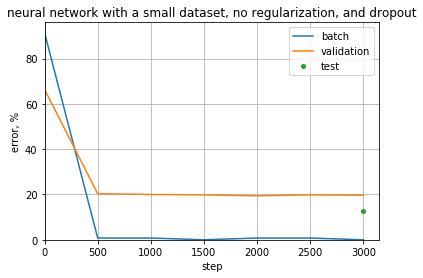

In [11]:
run('neural network with a small dataset, no regularization, and dropout',
    make_nn(), dropout_keep_prob=0.5,
    train_data=train_dataset[:1000, :], train_labels=train_labels[:1000, :])

running neural network with regularization and dropout
loss at step 0: 3577.1
batch accuracy: 13.3%
validation accuracy: 28.9%
loss at step 500: 21.5
batch accuracy: 78.9%
validation accuracy: 83.3%
loss at step 1000: 1.0
batch accuracy: 82.8%
validation accuracy: 83.2%
loss at step 1500: 0.8
batch accuracy: 81.2%
validation accuracy: 83.3%
loss at step 2000: 0.8
batch accuracy: 83.6%
validation accuracy: 83.7%
loss at step 2500: 0.7
batch accuracy: 86.7%
validation accuracy: 83.3%
loss at step 3000: 0.6
batch accuracy: 89.1%
validation accuracy: 83.5%
test accuracy: 89.6%


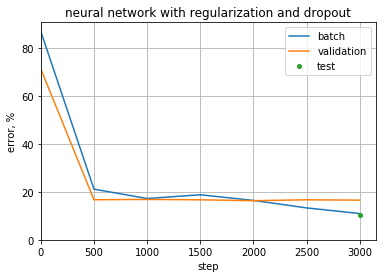

In [12]:
run('neural network with regularization and dropout',
    make_nn(), regularization_strength=0.01, dropout_keep_prob=0.5)

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [13]:
def make_adam(learning_rate=0.001):
    def train_fn(loss):
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss)
        return train_op
    return train_fn

running neural network with regularization and dropout, trained with Adam
loss at step 0: 3636.8
batch accuracy: 18.8%
validation accuracy: 15.6%
loss at step 500: 2421.0
batch accuracy: 74.2%
validation accuracy: 81.1%
loss at step 1000: 1683.6
batch accuracy: 75.8%
validation accuracy: 82.9%
loss at step 1500: 1123.3
batch accuracy: 75.0%
validation accuracy: 83.4%
loss at step 2000: 707.4
batch accuracy: 78.9%
validation accuracy: 83.8%
loss at step 2500: 434.8
batch accuracy: 79.7%
validation accuracy: 83.4%
loss at step 3000: 248.7
batch accuracy: 82.8%
validation accuracy: 83.6%
test accuracy: 90.4%


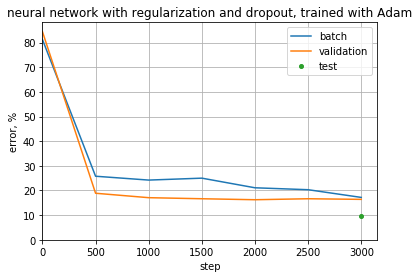

In [14]:
run('neural network with regularization and dropout, trained with Adam',
    make_nn(), regularization_strength=0.01, dropout_keep_prob=0.5,
    train_fn=make_adam())

running neural network with regularization and dropout, trained with Adam
loss at step 0: 3599.0
batch accuracy: 7.8%
validation accuracy: 5.4%
loss at step 500: 2414.0
batch accuracy: 73.4%
validation accuracy: 81.3%
loss at step 1000: 1682.1
batch accuracy: 78.1%
validation accuracy: 83.0%
loss at step 1500: 1120.8
batch accuracy: 79.7%
validation accuracy: 83.6%
loss at step 2000: 711.4
batch accuracy: 80.5%
validation accuracy: 84.0%
loss at step 2500: 437.5
batch accuracy: 75.8%
validation accuracy: 83.8%
loss at step 3000: 249.9
batch accuracy: 80.5%
validation accuracy: 83.3%
loss at step 3500: 139.2
batch accuracy: 83.6%
validation accuracy: 84.0%
loss at step 4000: 72.8
batch accuracy: 76.6%
validation accuracy: 84.4%
loss at step 4500: 36.4
batch accuracy: 80.5%
validation accuracy: 84.9%
loss at step 5000: 17.3
batch accuracy: 83.6%
validation accuracy: 85.5%
loss at step 5500: 8.6
batch accuracy: 81.2%
validation accuracy: 86.0%
loss at step 6000: 4.6
batch accuracy: 80.5%


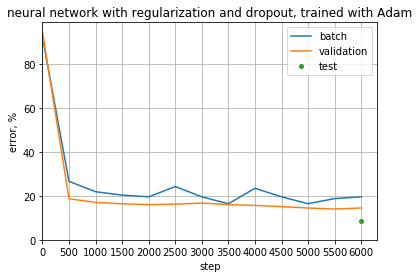

In [26]:
run('neural network with regularization and dropout, trained with Adam',
    make_nn(), regularization_strength=0.01, dropout_keep_prob=0.5,
    train_fn=make_adam(), num_steps=6001)